In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Metodos

In [3]:
#Metodo para alinear todos los datos de entrada
def create_dataframe(dataframe, path, files, features, max_rows):
    sorted_files = sorted(files)
    for file in sorted_files:
        df = pd.read_csv(path+file, sep=',', header=0, usecols=features)
        if(len(df.index)<max_rows):
            for i in range(len(df.index),max_rows):
                df = df.append(pd.Series(0, index=df.columns), ignore_index=True)
        else:
            for j in range(max_rows, len(df.index)):
                df = df.drop(j)            

        dataframe = dataframe.append(df, ignore_index=True)
    return dataframe

#Metodo para agrupar todas las etiquetas
def create_dataframe_label(dataframe, path, files):
    sorted_files = sorted(files)
    for file in sorted_files:
        df = pd.read_csv(path+file, sep=',', header=None)   
        dataframe = dataframe.append(df, ignore_index=True)
        
    output_array = dataframe.to_numpy()
    return output_array

#Metodo para generar datos adversos por medio de FGSM
def crear_patron_adverso(serie_tiempo, y_true):
    with tf.GradientTape() as tape:
        tape.watch(serie_tiempo)
        prediction = model(serie_tiempo)
        loss = loss_object(y_true,prediction)
        gradient = tape.gradient(loss, serie_tiempo)
        signed_grad = tf.sign(gradient)
        return signed_grad

# Variables

In [4]:
#Datos para entrenamiento y prueba
path_training_x = '/home/luisk/Documents/ProyectoDiversificacion/training/'
path_training_y = '/home/luisk/Documents/ProyectoDiversificacion/training_label/'
path_test_x = '/home/luisk/Documents/ProyectoDiversificacion/test/'
path_test_y = '/home/luisk/Documents/ProyectoDiversificacion/test_label/'
files_training_x = os.listdir(path_training_x)
files_training_y = os.listdir(path_training_y)
files_test_x = os.listdir(path_test_x)
files_test_y = os.listdir(path_test_y)

#Caracteristicas a usar
features = ['ALP','ALT','AST','Age','Albumin','BUN','Bilirubin','Cholesterol',
     'Creatinine','DiasABP','FiO2','GCS','Gender0','Gender1','Glucose','HCO3',
     'HCT','HR','Height','ICUType1','ICUType2','ICUType3','ICUType4','K','Lactate',
     'MAP','MechVent','Mg','NIDiasABP','NIMAP','NISysABP','Na','PaCO2','PaO2',
     'Platelets','RespRate','SaO2','SysABP','Temp','TroponinI','TroponinT','Urine','WBC','Weight','pH']

#Datos para entrenamiento y prueba
path_adversarial_x = '/home/luisk/Documents/ProyectoDiversificacion/adversarial/'
path_adversarial_y = '/home/luisk/Documents/ProyectoDiversificacion/adversarial_label/'
files_adversarial_x = os.listdir(path_adversarial_x)
files_adversarial_y = os.listdir(path_adversarial_y)

# Preprocesamiento de los datos

In [5]:
#Datos de entrenamiento X
dataframe_training_x = pd.DataFrame()
dataframe_training_x = create_dataframe(dataframe_training_x, path_training_x,
                                       files_training_x,features, 99)
array_training_x = dataframe_training_x.to_numpy()
array_training_x = array_training_x.reshape(3200,99,45)

#Etiquetas de entrenamiento Y
dataframe_training_y = pd.DataFrame()
array_training_y = create_dataframe_label(dataframe_training_y, path_training_y,
                                       files_training_y)

#Datos de prueba X
dataframe_test_x = pd.DataFrame()
dataframe_test_x = create_dataframe(dataframe_test_x, path_test_x,
                                       files_test_x,features, 99)
array_test_x = dataframe_test_x.to_numpy()
array_test_x = array_test_x.reshape(800,99,45)

#Datos de prueba Y
dataframe_test_y = pd.DataFrame()
array_test_y = create_dataframe_label(dataframe_test_y, path_test_y,
                                       files_test_y)

# Modelo - Crossentropy

In [6]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy', 'Precision', 'Recall'])
model.fit(array_training_x, array_training_y, epochs=10, batch_size=64)
print(model.summary())

Epoch 1/10
50/50 [==============================] - 4s 51ms/step - loss: 0.4370 - accuracy: 0.8591 - precision: 0.2000 - recall: 0.0115
Epoch 2/10
50/50 [==============================] - 3s 53ms/step - loss: 0.3817 - accuracy: 0.8653 - precision: 1.0000 - recall: 0.0115
Epoch 3/10
50/50 [==============================] - 3s 54ms/step - loss: 0.3660 - accuracy: 0.8641 - precision: 0.5067 - recall: 0.0872
Epoch 4/10
50/50 [==============================] - 3s 53ms/step - loss: 0.3434 - accuracy: 0.8737 - precision: 0.6633 - recall: 0.1491
Epoch 5/10
50/50 [==============================] - 3s 54ms/step - loss: 0.3631 - accuracy: 0.8697 - precision: 0.6667 - recall: 0.0872
Epoch 6/10
50/50 [==============================] - 3s 55ms/step - loss: 0.3408 - accuracy: 0.8744 - precision: 0.6635 - recall: 0.1583
Epoch 7/10
50/50 [==============================] - 3s 56ms/step - loss: 0.3237 - accuracy: 0.8784 - precision: 0.6822 - recall: 0.2018
Epoch 8/10
50/50 [==============================

# Evaluacion del modelo original

In [7]:
scores = model.evaluate(array_test_x, array_test_y, verbose=0 )
print("Exactitud: %.2f%%" %(scores[1]*100))
print("Precision: %.2f" %(scores[2]))
print("Exhaustividad: %.2f" %(scores[3]))

Exactitud: 85.00%
Precision: 0.48
Exhaustividad: 0.23


# Ataque # 1 - Crossentropy

In [8]:
#Funcion de perdida a usar en el ataque
loss_object = tf.keras.losses.binary_crossentropy

#Magnitud de la perturbacion Epsilon
array_adversarial_x = np.array
epsilon = 0.01

#Se atacan los mismos datos de prueba
signed_grad = crear_patron_adverso(tf.convert_to_tensor(array_test_x),
                                       tf.convert_to_tensor(array_test_y))

temp = array_test_x + epsilon*signed_grad
data_adversarial_x = temp.numpy()

### Comparacion de algunas caracteristicas alteradas

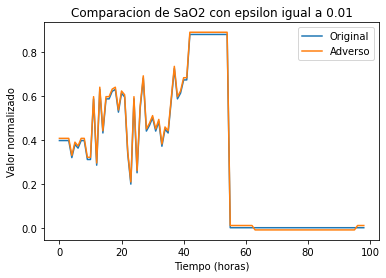

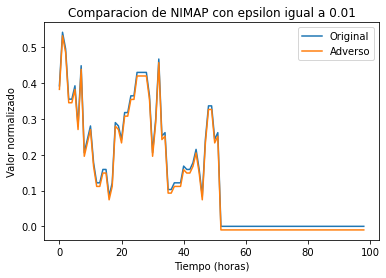

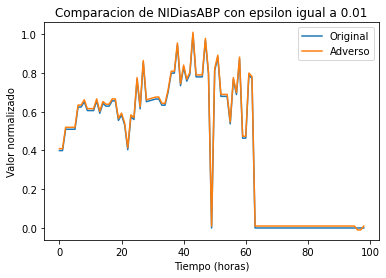

In [9]:
original = array_test_x
adverse = data_adversarial_x
#SaO2
plt.plot(original[2,:,37], label='Original')
plt.plot(adverse[2,:,37], label='Adverso')
plt.xlabel("Tiempo (horas)")
plt.ylabel("Valor normalizado")
plt.title("Comparacion de SaO2 con epsilon igual a "+ str(epsilon))
plt.legend()
plt.show()

#NIMAP
plt.plot(original[5,:,30], label='Original')
plt.plot(adverse[5,:,30], label='Adverso')
plt.xlabel("Tiempo (horas)")
plt.ylabel("Valor normalizado")
plt.title("Comparacion de NIMAP con epsilon igual a "+ str(epsilon))
plt.legend()
plt.show()

#NIDiasABP
plt.plot(original[8,:,29], label='Original')
plt.plot(adverse[8,:,29], label='Adverso')
plt.xlabel("Tiempo (horas)")
plt.ylabel("Valor normalizado")
plt.title("Comparacion de NIDiasABP con epsilon igual a "+ str(epsilon))
plt.legend()
plt.show()

### Evaluacion del Ataque # 1 - Crossentropy

In [10]:
scores_binary_crossentropy = model.evaluate(data_adversarial_x, array_test_y, verbose=0)
print("Exactitud: %.2f%%" %(scores_binary_crossentropy[1]*100))
print("Precision: %.2f" %(scores_binary_crossentropy[2]))
print("Exhaustividad: %.2f" %(scores_binary_crossentropy[3]))

Exactitud: 73.25%
Precision: 0.09
Exhaustividad: 0.09


# Ataque # 2 - Categorical Crossentropy

In [12]:
#Funcion de perdida a usar en el ataque
loss_object = tf.keras.losses.categorical_crossentropy

#Magnitud de la perturbacion Epsilon
array_adversarial_x = np.array
epsilon = 0.01

#Se atacan los mismos datos de prueba
signed_grad = crear_patron_adverso(tf.convert_to_tensor(array_test_x),
                                       tf.convert_to_tensor(array_test_y))

temp = array_test_x + epsilon*signed_grad
data_adversarial_x = temp.numpy()

### Comparacion de algunas caracteristicas alteradas

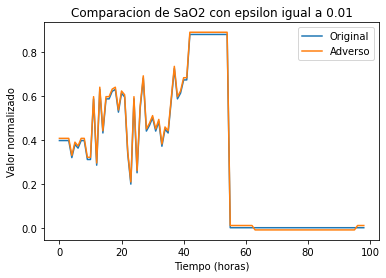

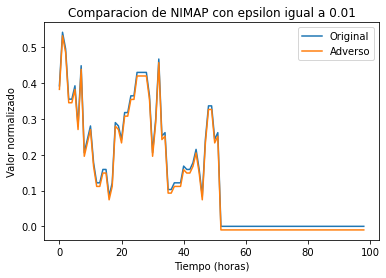

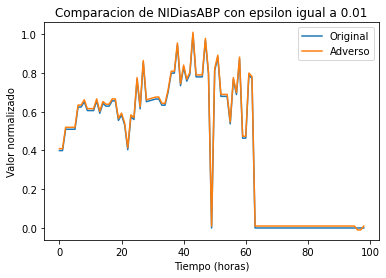

In [13]:
original = array_test_x
adverse = data_adversarial_x
#SaO2
plt.plot(original[2,:,37], label='Original')
plt.plot(adverse[2,:,37], label='Adverso')
plt.xlabel("Tiempo (horas)")
plt.ylabel("Valor normalizado")
plt.title("Comparacion de SaO2 con epsilon igual a "+ str(epsilon))
plt.legend()
plt.show()

#NIMAP
plt.plot(original[5,:,30], label='Original')
plt.plot(adverse[5,:,30], label='Adverso')
plt.xlabel("Tiempo (horas)")
plt.ylabel("Valor normalizado")
plt.title("Comparacion de NIMAP con epsilon igual a "+ str(epsilon))
plt.legend()
plt.show()

#NIDiasABP
plt.plot(original[8,:,29], label='Original')
plt.plot(adverse[8,:,29], label='Adverso')
plt.xlabel("Tiempo (horas)")
plt.ylabel("Valor normalizado")
plt.title("Comparacion de NIDiasABP con epsilon igual a "+ str(epsilon))
plt.legend()
plt.show()

### Evaluacion del Ataque # 2 - Categorical Crossentropy

In [14]:
scores_categorical_crossentropy = model.evaluate(data_adversarial_x, array_test_y, verbose=0)
print("Exactitud: %.2f%%" %(scores_categorical_crossentropy[1]*100))
print("Precision: %.2f" %(scores_categorical_crossentropy[2]))
print("Exhaustividad: %.2f" %(scores_categorical_crossentropy[3]))

Exactitud: 75.25%
Precision: 0.20
Exhaustividad: 0.23
